In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visializing
import seaborn as sns # data visualization
from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV, LassoCV, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1.Exploratory data analyst

#### a) First look at columns and missing data

Time to look on the dataset and do some analysis before heading on to the modeling. We have 9 features and one variable to predict. The first two features describe the location of the neigberhood: longitude and latitude. Other describes the total sum of rooms, bedrooms, population and households. Median income of the households and the median age of the houses. The last is the variable which we are going to predict is going to be the median value of the house.

In [2]:
train = pd.read_csv('housing.csv')
train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
# Dataset contains 20640 rows and 10 features 
train.shape

(20640, 10)

In [4]:
train.describe()
#there are only missing values in the 'total_bedrooms' column

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
print("Checking missing values in dataset")
print(train.isnull().any())
print ("Missing values {0:3d} in 'total_bedrooms'".format(sum(train.total_bedrooms.isnull())))
print ("Percentage of missing rows {0:2.3f}".format(100*sum(train.total_bedrooms.isnull())/train.shape[0]))

Checking missing values in dataset
longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool
Missing values 207 in 'total_bedrooms'
Percentage of missing rows 1.003


In [6]:
train.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [7]:
train.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

First expresions: 
-we have one categorical variable which shows the distance to the ocean with 5 unique values but only 4 which are significant for us.
-only one column have missing values, there are only 200rows~ 1% of whole dataset, one of the ideas is to impute data with mean or average of the column or just remove rows. I will probably remove it since the percentage is not that big and its not going to influence the model.

In [8]:
train.dropna(axis=0, how='any', inplace=True)

### b) Look at single features

   #### -house_median_value
   Lets start with 'median_house_value', Minimum value almost looks like a promotion price 14.999, sound almost too incredible to be true. The second peak around 500000 which does not look as good. Unfortunetly we can't ask the one who was collecting data about this reason. But I think we can assume that 500001 is the maximum value probably also describing values which are greater than this. It's bringing the problem that a misslabeled data can't create a precise model. I am going to remove it and generalize the model on a range up to 500000. 

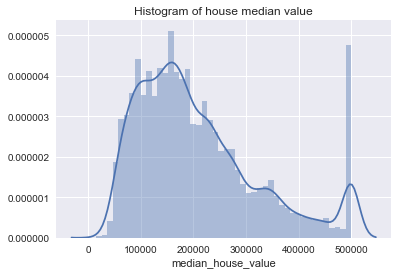

In [9]:
sns.distplot(train.median_house_value).set_title('Histogram of house median value')

In [10]:
print("The most often appearing values")
train.median_house_value.value_counts().sort_values(ascending=False).head(3)

The most often appearing values


500001.0    958
137500.0    119
162500.0    116
Name: median_house_value, dtype: int64

In [11]:
train= train.loc[(train.median_house_value<500001)]

In [12]:
print("Skewness of 'median_house value' {0:2f}".format(skew(train['median_house_value'])))
print("Skewness of 'median_house value' after using log {0:2f}".format(skew(np.log(train['median_house_value']))))

Skewness of 'median_house value' 0.810086
Skewness of 'median_house value' after using log -0.294440


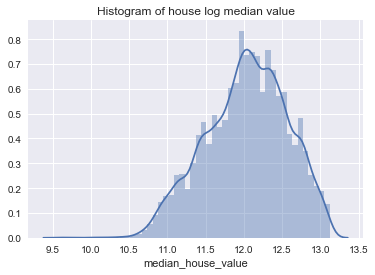

In [13]:
sns.distplot(np.log(train.median_house_value)).set_title('Histogram of house log median value')

In [14]:
print(skew(train['median_house_value']))
print(skew(np.log(train['median_house_value'])))

0.8100859862017087
-0.2944402457432595


#### -median_income
Time for other features. The median income distribution is little skeewed right and has 3 outliers 15.001. Probably its the same situation like with the house_mean_value, someone was saving maximum values with 0001 after decimal. 

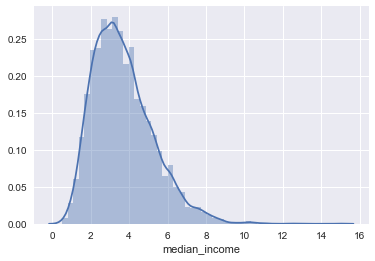

In [15]:
sns.distplot(train.median_income)

In [16]:
train.loc[(train.median_income>14)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1566,-121.96,37.74,2.0,200.0,20.0,25.0,9.0,15.0001,350000.0,<1H OCEAN
18501,-121.59,37.19,52.0,220.0,32.0,55.0,26.0,15.0001,131300.0,<1H OCEAN
18504,-121.96,37.13,26.0,50.0,5.0,17.0,4.0,15.0001,400000.0,<1H OCEAN


In [17]:
print(skew(train['median_income']))
print(skew(np.log(train['median_income'])))

0.9106616818538884
-0.3711654569125261


#### - housing_median_age
Next situation where distribution has some threshold and never crossing it. 

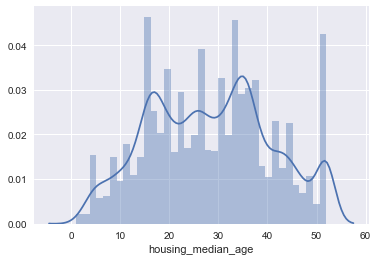

In [18]:
sns.distplot(train.housing_median_age )

In [19]:
print("Cardinality or house median age ")
train.housing_median_age.value_counts().sort_values(ascending=False).head(5)

Cardinality or house median age 


52.0    1096
36.0     816
35.0     783
16.0     747
17.0     680
Name: housing_median_age, dtype: int64

In [20]:
#train.housing_median_age=np.log(train.housing_median_age)

In [21]:
#train.housing_median_age=np.exp(train.housing_median_age)

In [22]:
#remove every observation which is 52 old and value bigger than 5000000
train_new= train.loc[((train.housing_median_age<52) & (train.median_house_value<500000 ))]

### -ocean_proximity
The only categorical variable available to show some insight. I can see some corelation and for example most of 'INLAND' places are quite cheap with small box so show have high concentration of observations. Fifty percentego of INLAND observation are in range between Q1=77500 and Q3=147900. But also 294 observations are above Q3+ 1.5*IQR and 108 above Q3+ 3*IQR  where IQR = Q3-Q1. What show quite big group of outliers. 

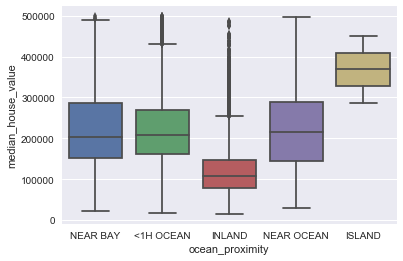

In [23]:
sns.boxplot(x='ocean_proximity', y='median_house_value',data=train_new)

In [24]:
train.ocean_proximity.value_counts()

<1H OCEAN     8505
INLAND        6469
NEAR OCEAN    2419
NEAR BAY      2077
ISLAND           5
Name: ocean_proximity, dtype: int64

In [25]:
print(" IQR = Q3-Q1=147900-77500=70400")
print("Amount of values above Q3 +1.5*IQR: {0:2.0f}".format(train_new['median_house_value'].loc[(train_new.ocean_proximity=='INLAND') & (train_new.median_house_value>253000)].count()))
print("Amount of values above Q3 +3*IQR: {0:2.0f}".format(train_new['median_house_value'].loc[(train_new.ocean_proximity=='INLAND') & (train_new.median_house_value>336027)].count()))


 IQR = Q3-Q1=147900-77500=70400
Amount of values above Q3 +1.5*IQR: 294
Amount of values above Q3 +3*IQR: 108


In [26]:
print("Basic statistics and quartile of median_house value for INLAND")
train_new['median_house_value'].loc[(train_new.ocean_proximity=='INLAND') ].describe()

Basic statistics and quartile of median_house value for INLAND


count      6289.000000
mean     123076.211957
std       65277.040805
min       14999.000000
25%       77500.000000
50%      108300.000000
75%      148000.000000
max      486800.000000
Name: median_house_value, dtype: float64

## 2. Feature enginering

This dataset contains features about the total of rooms, bedrooms, households, population. We can easily transform it to be more useful to tell us the average room per house, bedroom per house, people per house. 

In [27]:
# By having the total numbers we can count the average room per household, bed per household, people per household
train_new['room_avg_h']= train_new['total_rooms'] / train_new['households'] 
train_new['bed_avg_h'] = train_new['total_bedrooms'] / train_new['households'] 
train_new['pep_avg_h'] = train_new['population'] / train_new['households'] 


In [28]:
train_new.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
room_avg_h            False
bed_avg_h             False
pep_avg_h             False
dtype: bool

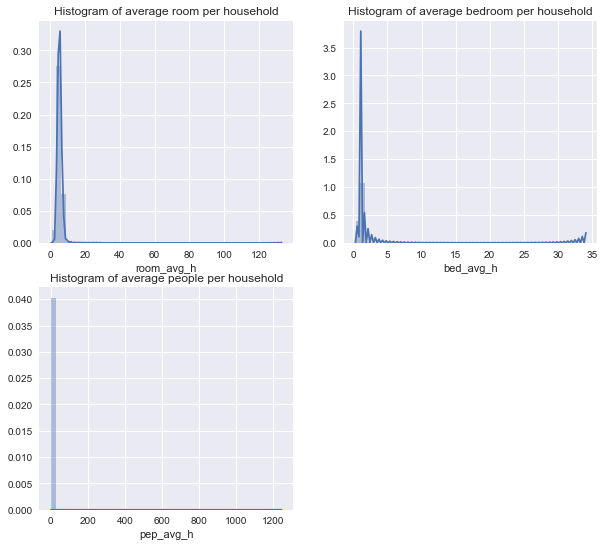

In [29]:
fig = plt.figure(figsize=(10, 9)) 
plt.subplot(2, 2, 1)
sns.distplot(train_new['room_avg_h']).set_title('Histogram of average room per household')
plt.subplot(2, 2, 2)
sns.distplot(train_new['bed_avg_h']).set_title('Histogram of average bedroom per household')
plt.subplot(2, 2, 3)
sns.distplot(train_new['pep_avg_h']).set_title('Histogram of average people per household')

There are some dirty outliers, more than average 500 people per house or 100 rooms doesn't loooks right for whole neighbourhod. I will remove it because some algorithms are highly influenced by the outliers. 

In [30]:
print("List of observations with average room per house greater than 100")
train_new.loc[(train_new['room_avg_h']>100),'room_avg_h'].round().value_counts()

List of observations with average room per house greater than 100


133.0    1
Name: room_avg_h, dtype: int64

In [31]:
print("List of observations with average bedroom per house greater than 20")
train_new.loc[(train_new['bed_avg_h']>20),'bed_avg_h'].round().value_counts()

List of observations with average bedroom per house greater than 20


34.0    1
Name: bed_avg_h, dtype: int64

In [32]:
print("List of observations with average people per house greater than 100")
train_new.loc[(train_new['pep_avg_h']>100),'pep_avg_h'].round().value_counts()

List of observations with average people per house greater than 100


1243.0    1
502.0     1
600.0     1
Name: pep_avg_h, dtype: int64

In [33]:
#removing outliers from the dataset
train_new= train_new.loc[((train_new.room_avg_h<100) & (train_new.bed_avg_h<20) &(train_new.pep_avg_h<30))]

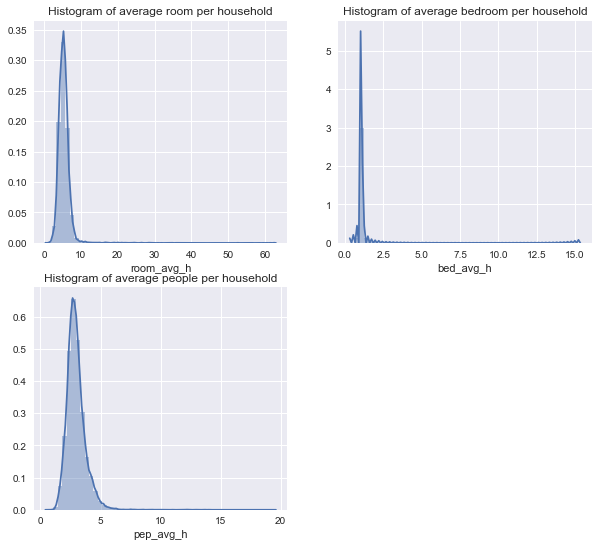

In [34]:
#ploting data without outliers
fig = plt.figure(figsize=(10, 9)) 
plt.subplot(2, 2, 1)
sns.distplot(train_new['room_avg_h']).set_title('Histogram of average room per household')
plt.subplot(2, 2, 2)
sns.distplot(train_new['bed_avg_h']).set_title('Histogram of average bedroom per household')
plt.subplot(2, 2, 3)
sns.distplot(train_new['pep_avg_h']).set_title('Histogram of average people per household')

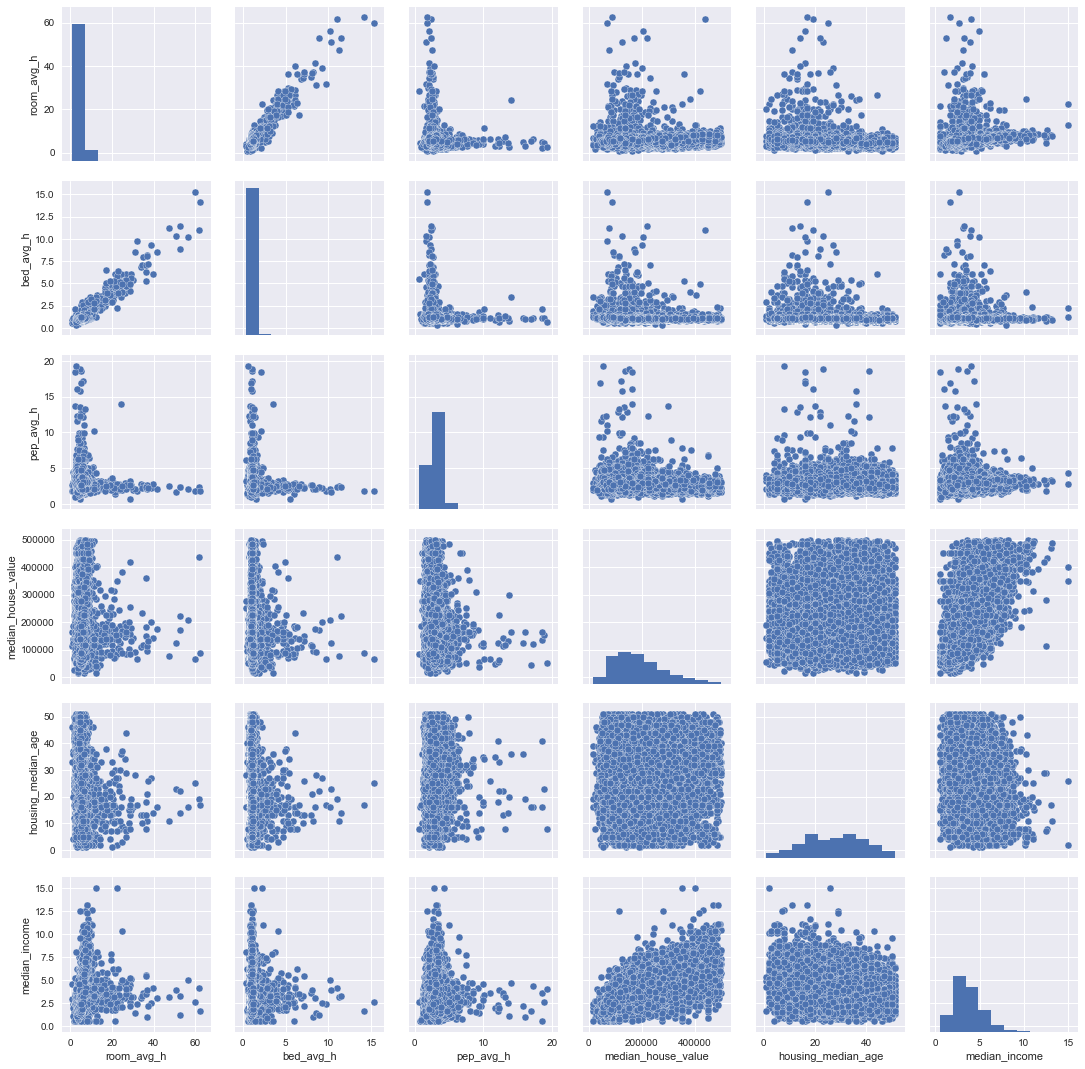

In [35]:
sns.pairplot(train_new[['room_avg_h','bed_avg_h','pep_avg_h', 'median_house_value','housing_median_age','median_income']])

### Heatmap
Time to look on heatmap of correletion of different features. Four input features show extremely high collinearity (total_rooms, total_bedrooms, population, households) I don't need all of them and I'm going to leave only households for further analysis. Other pair is longtitude and latitude but this doesn't affect us much. What the most interesting is how features are correlated with median_house_value, its strong positive correlation with median_income, moderate negative with ocean_proximity(INLAND) and weak positive with places '1<H OcEAN'. 

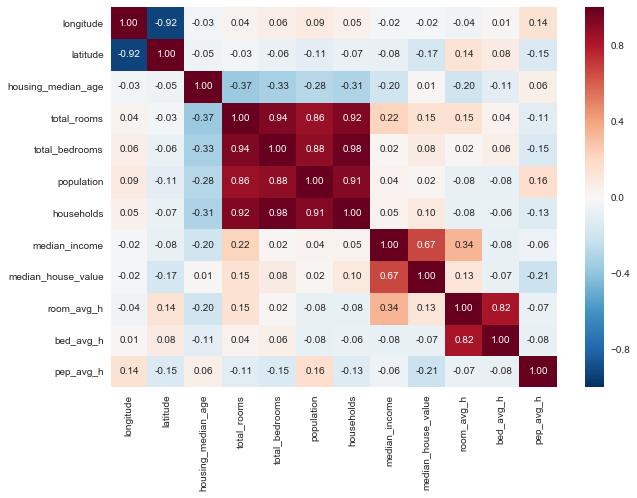

In [38]:
plt.figure(figsize=(10, 7)) 
sns.heatmap(train_new.corr(),annot=True, fmt=".2f")

### Localization - longitude and latitude.
    By using both we can visualize the general shape of the area, it looks like California so its good. Size of the marker show the number of households in a neighbourhood and color the median value. It easy to notice big cities on the coast where pricies are higher. I am going to use clustering to get more data.

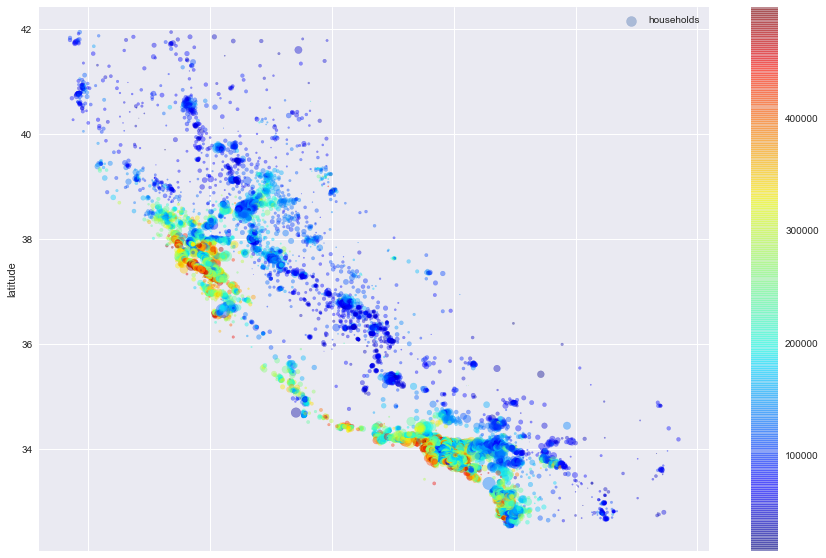

In [39]:
train_new.plot(kind = "scatter", x= "longitude", y = "latitude", alpha = 0.4, s = train_new["households"]/30, 
             label = "households", figsize=(15,10), c=train_new['median_house_value'],cmap = plt.get_cmap("jet"), colorbar = True)
plt.legend()

To find clusters im using DBSCAN - Density-Based Spatial Clustering of Applications with Noise, the algorithm is implemented in Sklearn library. I will create clusters of people that can bring some extra information to the algorithm.

In [40]:
clust= DBSCAN(eps=0.2).fit(train_new[['longitude', 'latitude']])

In [41]:
np.unique(clust.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18], dtype=int64)

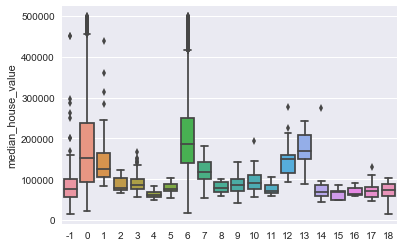

In [42]:
sns.boxplot(y=train_new['median_house_value'], x=clust.labels_)

In [43]:
train_new['cluster'] =clust.labels_
train_new['cluster']=train_new['cluster'].astype('category')
#train_new=pd.get_dummies(train_new, drop_first=True)

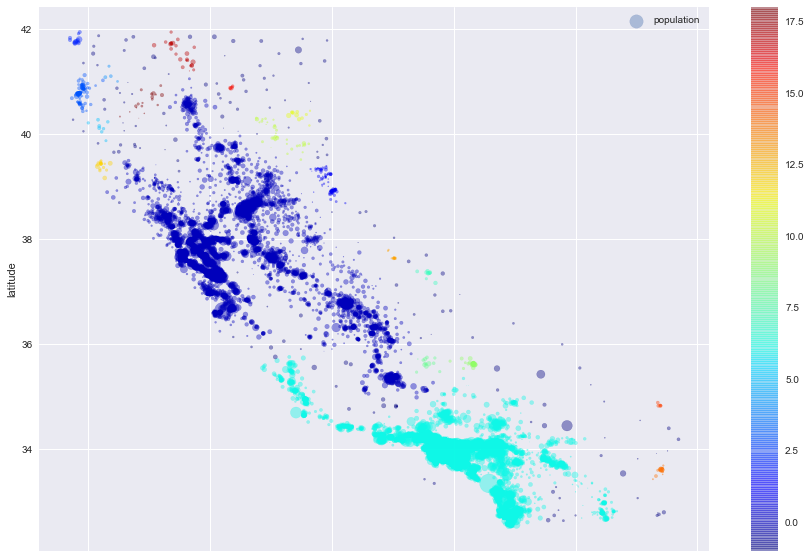

In [44]:
train_new.plot(kind = "scatter", x= "longitude", y = "latitude", alpha = 0.4, s = train_new["population"]/100, 
             label = "population", figsize=(15,10), c=train_new["cluster"],cmap = plt.get_cmap("jet"), colorbar = True)
plt.legend()

Clustering created one column with 20 different numerical variables (-1...18) but it doesn't mean that 1 is close to 2 in any way. So we need to create dummy variables. What mean create sparse matrix with 19 binary columns. Observation has value 1 in one column correspond to the cluster which belong and 0 in others. 

In [45]:
train_new=pd.get_dummies(train_new, drop_first=True)

In [46]:
train_new.drop(['total_rooms','total_bedrooms','population'],axis=1, inplace=True)

In [47]:
train_new.head()

,longitude,latitude,housing_median_age,households,median_income,median_house_value,room_avg_h,bed_avg_h,pep_avg_h,ocean_proximity_INLAND,...,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18
0,-122.23,37.88,41.0,126.0,8.3252,452600.0,6.984127,1.023810,2.555556,0,...,0,0,0,0,0,0,0,0,0,0
1,-122.22,37.86,21.0,1138.0,8.3014,358500.0,6.238137,0.971880,2.109842,0,...,0,0,0,0,0,0,0,0,0,0
8,-122.26,37.84,42.0,595.0,2.0804,226700.0,4.294118,1.117647,2.026891,0,...,0,0,0,0,0,0,0,0,0,0
15,-122.26,37.85,50.0,264.0,2.1250,140000.0,4.242424,1.071970,2.640152,0,...,0,0,0,0,0,0,0,0,0,0
18,-122.26,37.84,50.0,419.0,1.9911,158700.0,5.343675,1.085919,2.362768,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#one cell transition
train = pd.read_csv('housing.csv')
train.dropna(axis=0, how='any', inplace=True)
#remove every observation which is 52 old and value bigger than 5000000
train_new= train.loc[((train.housing_median_age<52) & (train.median_house_value<500000 ))]
#train_new=train
# By having total numbers we can count average room per household, bed per household, people per household
train_new['room_avg_h']= train_new['total_rooms'] / train_new['households'] 
train_new['bed_avg_h'] = train_new['total_bedrooms'] / train_new['households'] 
train_new['pep_avg_h'] = train_new['population'] / train_new['households']
train_new= train_new.loc[((train_new.room_avg_h<100) & (train_new.bed_avg_h<20) &(train_new.pep_avg_h<30)&(train_new.median_income<15))]
train_new['longitude'] = -train_new['longitude']
train_new=pd.get_dummies(train_new)

In [48]:
train_new.longitude=-train_new.longitude

In [50]:
train_new.iloc[:,0:9]=train_new.iloc[:,0:9].apply(np.log1p)


## 2. Training
I want to start with a simple model like just Lasso and then move to a more complex ensamble method like a random forest. General I will use a root mean square logistic error as loss function.
First step is to split the data 80/20 as a training and test dataset and after scale every column to mean=0 and std=1.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(train_new.drop(['median_house_value' ], axis=1), train_new['median_house_value'], test_size=0.20, random_state=42)

In [53]:
X_train_s = preprocessing.scale(X_train)
X_test_s = preprocessing.scale(X_test)

### a) Lasso model
Linear Model trained with L1 prior as regularizer. Alpha is the only hyper parameter to tune. Additionaly I'm using GridSearchCv from sklearn which take as arguments model, parameters and other attributes like how many cross fold validation there is.
GridSearchCv is checking all possible combination so if we want to check parameter alpha (7 different values) and beta (5 different) with a cross validation 5 he is going to fit 175 models 7*5*5. 

In [88]:
parameters = [{'alpha':[0.00001,0.0001,0.002, 0.004, 0.05, 0.1]}]
LA_model = Lasso()
clf_LA=GridSearchCV(LA_model, parameters, verbose=3, cv=5)
clf_LA.fit(X_train_s,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] alpha=1e-05 .....................................................
[CV] ...................... alpha=1e-05, score=0.721969, total=   1.3s
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ...................... alpha=1e-05, score=0.702656, total=   1.2s
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s


[CV] ...................... alpha=1e-05, score=0.702760, total=   1.5s
[CV] alpha=1e-05 .....................................................
[CV] ...................... alpha=1e-05, score=0.690211, total=   1.7s
[CV] alpha=1e-05 .....................................................
[CV] ...................... alpha=1e-05, score=0.708412, total=   1.3s
[CV] alpha=0.0001 ....................................................
[CV] ..................... alpha=0.0001, score=0.722047, total=   0.9s
[CV] alpha=0.0001 ....................................................
[CV] ..................... alpha=0.0001, score=0.702564, total=   0.8s
[CV] alpha=0.0001 ....................................................
[CV] ..................... alpha=0.0001, score=0.702783, total=   0.9s
[CV] alpha=0.0001 ....................................................
[CV] ..................... alpha=0.0001, score=0.690410, total=   1.0s
[CV] alpha=0.0001 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'alpha': [1e-05, 0.0001, 0.002, 0.004, 0.05, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

Argument best_estimator returns a set of parameters of best model.

In [89]:
clf_LA.best_estimator_

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [90]:
y_pred_LA=clf_LA.best_estimator_.predict(X_test_s)
MSE_LA=mean_squared_error(np.expm1(y_test), np.expm1(y_pred_LA))**(1/2)
print("Root mean square error of Lasso model {0:3f}".format(MSE_LA))

Root mean square error of Lasso model 57654.139587


In [91]:
clf_LA.cv_results_['mean_test_score']

array([ 0.70520239,  0.70522191,  0.70354414,  0.69882273,  0.63207908,
        0.56436225])

In [92]:
alphas=[0.00001,0.0001,0.002, 0.004, 0.05, 0.1]

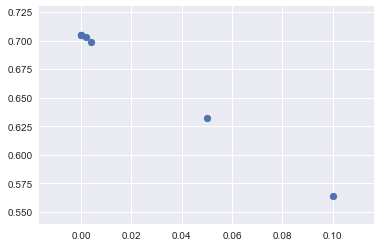

In [93]:
plt.scatter(alphas, clf_LA.cv_results_['mean_test_score'] )

## b) Random forest
The algorithm is creating a forest of decision trees. Its an ensemble method which use many trees from forest to avoid the common problem of overfiting to data. Its generalizng well and have a few parameters to tune. For exampel: 'n_estimators' - number trees in model, 'max_depth' how deep is going to be tree, 'min_samples_split'- minimum number of observations to split and several more parameters.

In [ ]:
parameters = [{'n_estimators':[100,200,500]}]

In [71]:
# parameters and ranges to plot
param_grid = {"n_estimators": [200],
              "max_depth": np.arange(21, 36, 3),
              'min_samples_split': [5,10,20],
             }

In [72]:
RF_model = RandomForestRegressor(random_state=44)

In [73]:
clf=GridSearchCV(RF_model, param_grid, verbose=3, cv=5)

In [74]:
clf.fit(X_train_s,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] max_depth=21, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=21, min_samples_split=5, n_estimators=100, score=0.819231, total=  15.1s
[CV] max_depth=21, min_samples_split=5, n_estimators=100 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s remaining:    0.0s


[CV]  max_depth=21, min_samples_split=5, n_estimators=100, score=0.817275, total=  17.9s
[CV] max_depth=21, min_samples_split=5, n_estimators=100 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.3s remaining:    0.0s


[CV]  max_depth=21, min_samples_split=5, n_estimators=100, score=0.817993, total=  15.3s
[CV] max_depth=21, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=21, min_samples_split=5, n_estimators=100, score=0.819015, total=  14.8s
[CV] max_depth=21, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=21, min_samples_split=5, n_estimators=100, score=0.819847, total=  14.2s
[CV] max_depth=21, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=21, min_samples_split=10, n_estimators=100, score=0.818615, total=  14.0s
[CV] max_depth=21, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=21, min_samples_split=10, n_estimators=100, score=0.815071, total=  13.4s
[CV] max_depth=21, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=21, min_samples_split=10, n_estimators=100, score=0.816332, total=  14.2s
[CV] max_depth=21, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=21, min_samples_split

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 17.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=44,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100], 'max_depth': array([21, 24, 27, 30, 33]), 'min_samples_split': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

In [75]:
clf.cv_results_['mean_test_score']

array([ 0.81867208,  0.81728649,  0.81289276,  0.81887714,  0.81724149,
        0.81279891,  0.81883154,  0.81733902,  0.81281324,  0.81881553,
        0.81729084,  0.81287893,  0.81885605,  0.81731034,  0.81283389])

In [82]:
y_pred_RF=clf.best_estimator_.predict(X_test_s)

In [83]:
clf.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=24,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=44,
           verbose=0, warm_start=False)

In [84]:
mean_squared_error(np.expm1(y_test), np.expm1(y_pred_RF))**(1/2)

47314.709452002127

In [85]:
error = ((np.expm1(y_test) -np.expm1(y_pred_RF))**2)**(1/2)

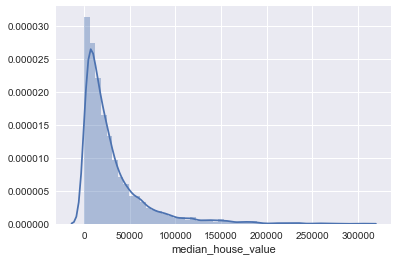

In [86]:
sns.distplot(error)

## c) XGBoost
A new algorithm which is very popular and succesful during data science competitions. XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.

In [78]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)


In [97]:
model_xgb = xgb.XGBRegressor(n_estimators=560, max_depth=10, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=560,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [98]:
xgb_preds = model_xgb.predict(X_test)

In [99]:
mean_squared_error(np.expm1(y_test), np.expm1(xgb_preds))**(1/2)

42486.964384161249

In [ ]:
sum(np.isnan(y_test))